In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/tmp/ipykernel_5350/2127772965.py:5: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage
2025-07-26 18:33:50.865735: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-26 18:33:51.002796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-26 18:33:51.002855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-26 18:33:51.025906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to regi

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [2]:
k = 20 # Top 10% highest l2-magnitude filters

In [3]:
F = 0

filters = np.zeros((3,3,1,1))

t = np.zeros((3,3))
t[1, 0] = np.sqrt(0.75)
t[0, 0] = np.sqrt(0.25)
filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)) 
filters /= np.sum(np.abs(filters))

#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})




(3, 3, 1, 1)
(1, 3, 3, 1) (1, 3, 3, 1) (1, 3, 3, 1)


2025-07-26 18:33:52.465129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-26 18:33:52.633464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-26 18:33:52.636025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
3//2

1

In [5]:
#var = 2/(128*9)

img = np.zeros((115,115)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(115, 115)


In [6]:
np.var(img), 1/(128*9)


(7.560864919722271e-05, 0.0008680555555555555)

In [7]:
np.linspace(-round(0.1)-1, round(0.1)+1, int(0.5*(0.1)+3))

array([-1.,  0.,  1.])

(3, 3, 1, 1)
0
(1, 115, 115, 1)
VALS 1.0


2025-07-26 18:33:53.038163: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-07-26 18:33:53.038177: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-07-26 18:33:53.038190: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-07-26 18:33:53.038198: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

tf.Tensor(-0.5, shape=(), dtype=float32) 0.0
(1, 115, 115, 1)


2025-07-26 18:33:53.376467: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-26 18:33:53.459524: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-07-26 18:33:53.461254: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-07-26 18:33:53.628788: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-07-26 18:33:53.630458: W ten

1
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(0.26400283, shape=(), dtype=float32) 0.43243995
(1, 115, 115, 1)
2
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(1.1235939, shape=(), dtype=float32) 0.49214745
(1, 115, 115, 1)
3
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(2.0319264, shape=(), dtype=float32) 0.5042868
(1, 115, 115, 1)
4
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(2.968467, shape=(), dtype=float32) 0.50053185
(1, 115, 115, 1)
5
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(3.8957834, shape=(), dtype=float32) 0.52261436
(1, 115, 115, 1)
6
(1, 115, 115, 1)
VALS 0.9999999
tf.Tensor(4.8001904, shape=(), dtype=float32) 0.57136804
(1, 115, 115, 1)
7
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(5.6991634, shape=(), dtype=float32) 0.61652535
(1, 115, 115, 1)
8
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(6.60256, shape=(), dtype=float32) 0.6488574
(1, 115, 115, 1)
9
(1, 115, 115, 1)
VALS 1.0
tf.Tensor(7.5149145, shape=(), dtype=float32) 0.66830313
(1, 115, 115, 1)


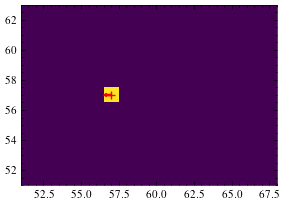

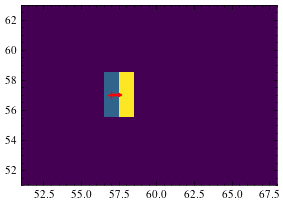

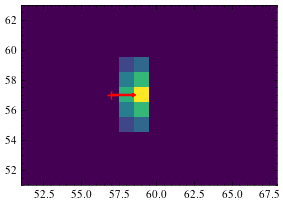

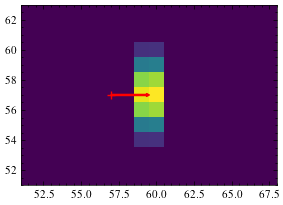

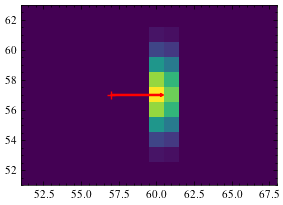

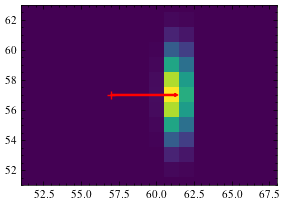

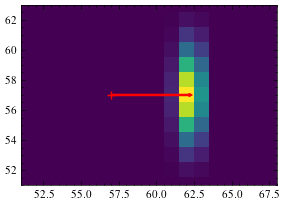

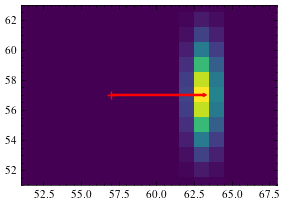

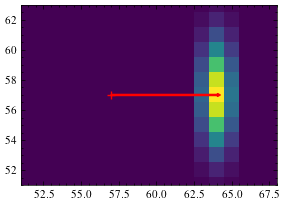

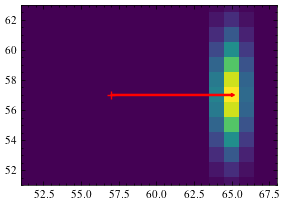

In [8]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/prop_unipolar_0.75"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(10):
	print(i)
	#if i in [0, 19, 39, 59, 79]:
	fig, ax = plt.subplots()
	print(x.shape)
	x = x/np.std(x)
	vals = x[0, x.shape[1]//2, :, :]
	vals = vals/np.sum(vals)

	print("VALS", np.sum(vals))
	pos = np.expand_dims(np.linspace(-x.shape[1]//2, x.shape[1]//2, x.shape[1]),-1)
	mean = tf.reduce_sum(pos*vals)
	var = tf.reduce_sum(((pos-mean)**2) * vals)
	std = np.sqrt(var)
	print(mean, np.sqrt(var))
	
	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)

	im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
	ax.plot(mid, mid, marker = '+', color='red')

	#ax.plot(112+mean, 112, marker = ".", color='black')
	arr =  mpatches.FancyArrowPatch((mid, mid), (mid+mean+std, mid),
							mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
	ax.add_patch(arr)
	
	#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
	#ax.arrow(, 112, dx=, dy= 0, color='black')

	ax.set(xlim=( (mid-(5)-1), (mid+(10)+1)), ylim=((mid-(5)-1), (mid+(5)+1)))
	#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
	#fig.colorbar(im, orientation='vertical')
	fig.savefig(directory + f'/{i}.pdf', dpi=150,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )

(0.0, 224.0)

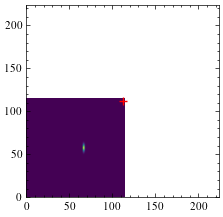

In [9]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

In [10]:
pos[:, x.shape[1]//2, : , :]

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
pos

In [ ]:
pos[x.shape[1]//2]